#Spam model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH_MALWARE = "/content/drive/MyDrive/Datasets/2malware/Malware-dataset.csv"
DATA_PATH_SPAM = "/content/drive/MyDrive/Datasets/2spam/emails.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#DATA_PATH_MALWARE = "/Datasets/2malware/Malware-dataset.csv"
#DATA_PATH_SPAM = "/Datasets/2spam/emails.csv"

#Preprocessing

SPAM DETECTION - DATA LOADING AND EXPLORATION


<>:107: SyntaxWarning: invalid escape sequence '\?'
<>:108: SyntaxWarning: invalid escape sequence '\$'
<>:107: SyntaxWarning: invalid escape sequence '\?'
<>:108: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-4235543077.py:107: SyntaxWarning: invalid escape sequence '\?'
  spam['question_count'] = spam['text'].str.count('\?')
/tmp/ipython-input-4235543077.py:108: SyntaxWarning: invalid escape sequence '\$'
  spam['dollar_count'] = spam['text'].str.count('\$')



Dataset loaded successfully!
Shape: (5728, 2)

First few rows:
                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1

DATA EXPLORATION

Dataset Info:
Total samples: 5728
Features: ['text', 'spam']

Missing values:
No missing values found!

Class distribution:
spam
0    4360
1    1368
Name: count, dtype: int64

Class proportions:
spam
0    0.761173
1    0.238827
Name: proportion, dtype: float64

Duplicate rows: 33
⚠️  Duplicates detected - will remove them
After removing duplicates: 5695 samples

Text Statistics:
        text_length   word_count
count   5695.000000  5695.000000
mean    1558.067076   327.079543
std     2047.078711   419.598400
min       13.000000     2.000000
25%      508.500

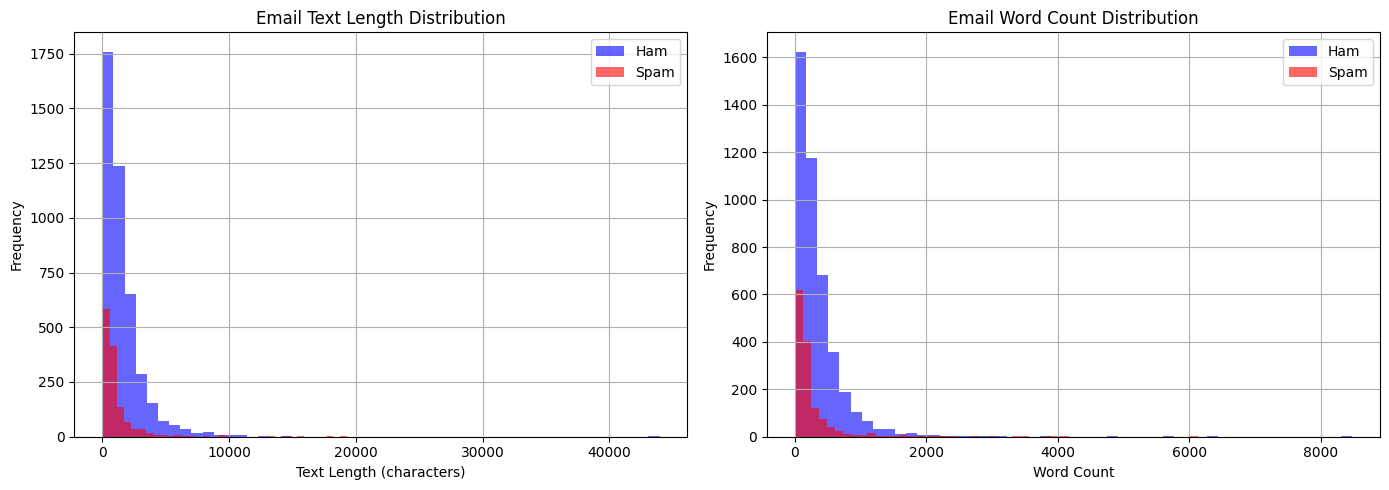


FEATURE EXTRACTION

Extracting features from text data...

Generating TF-IDF features...
✓ TF-IDF features created: 100 features
✓ Vocabulary size: 100

Combining all features...

✓ Total features: 116
  - Manual features: 16
  - TF-IDF features: 100

TRAIN-VALIDATION-TEST SPLIT

Dataset splits:
  Training: 3988 samples (70.0%)
  Validation: 852 samples (15.0%)
  Test: 855 samples (15.0%)

Class distribution in splits:
  Train - Ham: 3030, Spam: 958
  Val - Ham: 647, Spam: 205
  Test - Ham: 650, Spam: 205

FEATURE SCALING
✓ Applied StandardScaler to all datasets
✓ Scaler fitted on training data only (prevents data leakage)

Sample statistics after scaling:
  Mean: -0.000000 (should be ~0)
  Std: 0.995680 (should be ~1)

PREPROCESSING SUMMARY

✓ Dataset: 5695 emails
✓ Features extracted: 116
  - Manual features: 16
  - TF-IDF features: 100
✓ Class balance: Ham 4327 | Spam 1368
✓ Train/Val/Test split: 3988/852/855
✓ No data leakage - proper splitting applied
✓ Features scaled for Logist

In [8]:
# ==========================================
# SPAM DETECTION - DATA PREPROCESSING
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("SPAM DETECTION - DATA LOADING AND EXPLORATION")
print("="*70)

# Load spam dataset from Google Drive
spam = pd.read_csv(DATA_PATH_SPAM)

print(f"\nDataset loaded successfully!")
print(f"Shape: {spam.shape}")
print(f"\nFirst few rows:")
print(spam.head())

# ==========================================
# STEP 1: DATA EXPLORATION
# ==========================================

print("\n" + "="*70)
print("DATA EXPLORATION")
print("="*70)

print(f"\nDataset Info:")
print(f"Total samples: {len(spam)}")
print(f"Features: {list(spam.columns)}")

# Check for missing values
print(f"\nMissing values:")
missing = spam.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found!")

# Check class distribution
print(f"\nClass distribution:")
print(spam['spam'].value_counts())
print(f"\nClass proportions:")
print(spam['spam'].value_counts(normalize=True))

# Check for duplicates
print(f"\nDuplicate rows: {spam.duplicated().sum()}")
if spam.duplicated().sum() > 0:
    print("⚠️  Duplicates detected - will remove them")
    spam = spam.drop_duplicates()
    print(f"After removing duplicates: {len(spam)} samples")

# Text length analysis
spam['text_length'] = spam['text'].str.len()
spam['word_count'] = spam['text'].str.split().str.len()

print(f"\nText Statistics:")
print(spam[['text_length', 'word_count']].describe())

print(f"\nText length by class:")
print(spam.groupby('spam')[['text_length', 'word_count']].mean())

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Text length distribution
spam[spam['spam'] == 0]['text_length'].hist(bins=50, alpha=0.6, label='Ham', ax=axes[0], color='blue')
spam[spam['spam'] == 1]['text_length'].hist(bins=50, alpha=0.6, label='Spam', ax=axes[0], color='red')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Email Text Length Distribution')
axes[0].legend()

# Word count distribution
spam[spam['spam'] == 0]['word_count'].hist(bins=50, alpha=0.6, label='Ham', ax=axes[1], color='blue')
spam[spam['spam'] == 1]['word_count'].hist(bins=50, alpha=0.6, label='Spam', ax=axes[1], color='red')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Email Word Count Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# ==========================================
# STEP 2: FEATURE EXTRACTION
# ==========================================

print("\n" + "="*70)
print("FEATURE EXTRACTION")
print("="*70)

print("\nExtracting features from text data...")

# 1. Basic text features
spam['char_count'] = spam['text'].str.len()
spam['word_count'] = spam['text'].str.split().str.len()
spam['avg_word_length'] = spam['char_count'] / spam['word_count']

# 2. Special character counts
spam['exclamation_count'] = spam['text'].str.count('!')
spam['question_count'] = spam['text'].str.count('\?')
spam['dollar_count'] = spam['text'].str.count('\$')
spam['caps_count'] = spam['text'].str.count('[A-Z]')

# 3. Keyword presence (common spam indicators)
spam_keywords = ['free', 'win', 'winner', 'cash', 'prize', 'offer', 'click', 'urgent', 'limited']
for keyword in spam_keywords:
    spam[f'has_{keyword}'] = spam['text'].str.lower().str.contains(keyword).astype(int)

# 4. TF-IDF features (most important for text classification)
print("\nGenerating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=100,  # Top 100 most important words
    stop_words='english',  # Remove common words like 'the', 'is', etc.
    min_df=2,  # Word must appear in at least 2 documents
    max_df=0.95,  # Ignore words that appear in >95% of documents
    ngram_range=(1, 2)  # Use both single words and word pairs
)

# Fit TF-IDF on all text data
tfidf_features = tfidf.fit_transform(spam['text'])
tfidf_df = pd.DataFrame(
    tfidf_features.toarray(),
    columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])]
)

print(f"✓ TF-IDF features created: {tfidf_features.shape[1]} features")
print(f"✓ Vocabulary size: {len(tfidf.vocabulary_)}")

# Combine all features
print("\nCombining all features...")
manual_features = spam[[
    'char_count', 'word_count', 'avg_word_length',
    'exclamation_count', 'question_count', 'dollar_count', 'caps_count'
] + [f'has_{kw}' for kw in spam_keywords]]

# Combine manual features with TF-IDF
X_combined = pd.concat([manual_features.reset_index(drop=True), tfidf_df], axis=1)
y = spam['spam'].values

print(f"\n✓ Total features: {X_combined.shape[1]}")
print(f"  - Manual features: {manual_features.shape[1]}")
print(f"  - TF-IDF features: {tfidf_df.shape[1]}")

# ==========================================
# STEP 3: TRAIN-VAL-TEST SPLIT
# ==========================================

print("\n" + "="*70)
print("TRAIN-VALIDATION-TEST SPLIT")
print("="*70)

# Split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_combined, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nDataset splits:")
print(f"  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_combined)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_combined)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_combined)*100:.1f}%)")

print(f"\nClass distribution in splits:")
print(f"  Train - Ham: {(y_train == 0).sum()}, Spam: {(y_train == 1).sum()}")
print(f"  Val - Ham: {(y_val == 0).sum()}, Spam: {(y_val == 1).sum()}")
print(f"  Test - Ham: {(y_test == 0).sum()}, Spam: {(y_test == 1).sum()}")

# ==========================================
# STEP 4: FEATURE SCALING
# ==========================================

print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)

# Scale features (fit on training data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Applied StandardScaler to all datasets")
print("✓ Scaler fitted on training data only (prevents data leakage)")
print(f"\nSample statistics after scaling:")
print(f"  Mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"  Std: {X_train_scaled.std():.6f} (should be ~1)")

# ==========================================
# SUMMARY
# ==========================================

print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)

print(f"\n✓ Dataset: {len(spam)} emails")
print(f"✓ Features extracted: {X_combined.shape[1]}")
print(f"  - Manual features: {manual_features.shape[1]}")
print(f"  - TF-IDF features: {tfidf_df.shape[1]}")
print(f"✓ Class balance: Ham {(y == 0).sum()} | Spam {(y == 1).sum()}")
print(f"✓ Train/Val/Test split: {X_train.shape[0]}/{X_val.shape[0]}/{X_test.shape[0]}")
print(f"✓ No data leakage - proper splitting applied")
print(f"✓ Features scaled for Logistic Regression")

#Model Training

SPAM DETECTION - MODEL TRAINING

Dataset: 3988 training samples, 852 validation samples
Features: 116 (16 manual + 100 TF-IDF)
Task: Binary classification (Ham=0, Spam=1)

----------------------------------------------------------------------
1. LOGISTIC REGRESSION
----------------------------------------------------------------------
Training time: 0.2496 seconds
Inference time: 0.0031 seconds

Validation Metrics:
  Accuracy:  0.9707
  Precision: 0.9327 (of predicted spam, how many are actually spam)
  Recall:    0.9463 (of actual spam, how many did we catch)
  F1-Score:  0.9395
  ROC-AUC:   0.9938

Confusion Matrix:
[[633  14]
 [ 11 194]]
True Negatives (Ham→Ham): 633
False Positives (Ham→Spam): 14 ⚠️
False Negatives (Spam→Ham): 11 ⚠️
True Positives (Spam→Spam): 194

----------------------------------------------------------------------
2. DECISION TREE
----------------------------------------------------------------------
Training time: 0.1193 seconds
Inference time: 0.0057 seconds


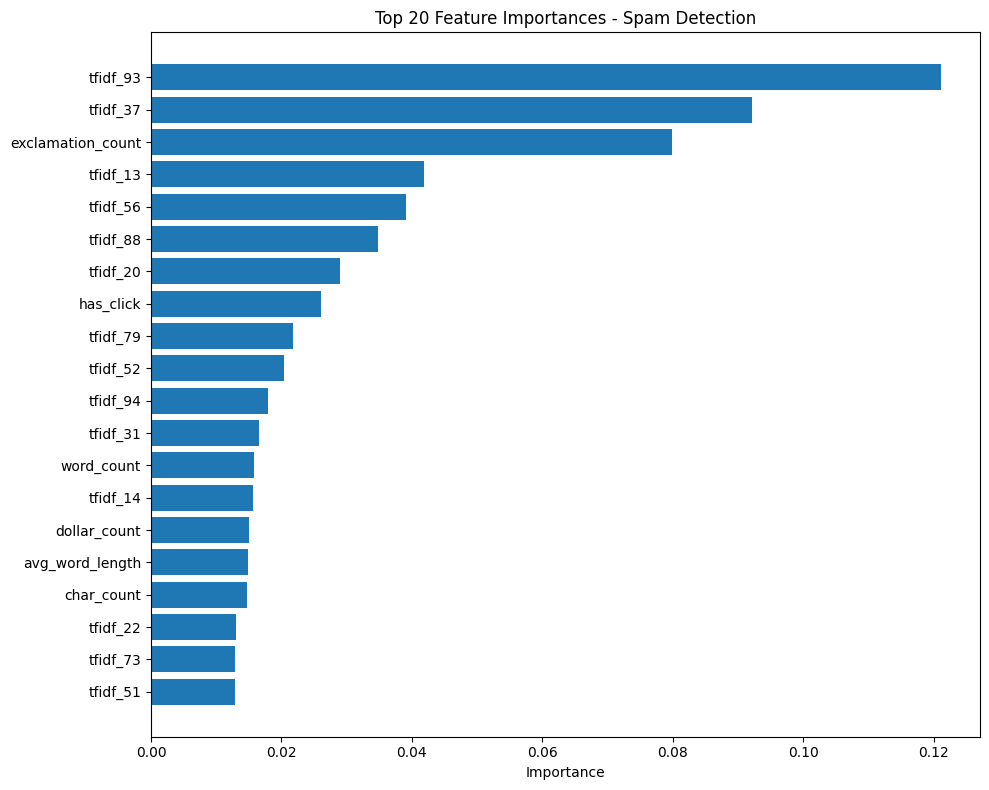


ROC CURVE COMPARISON


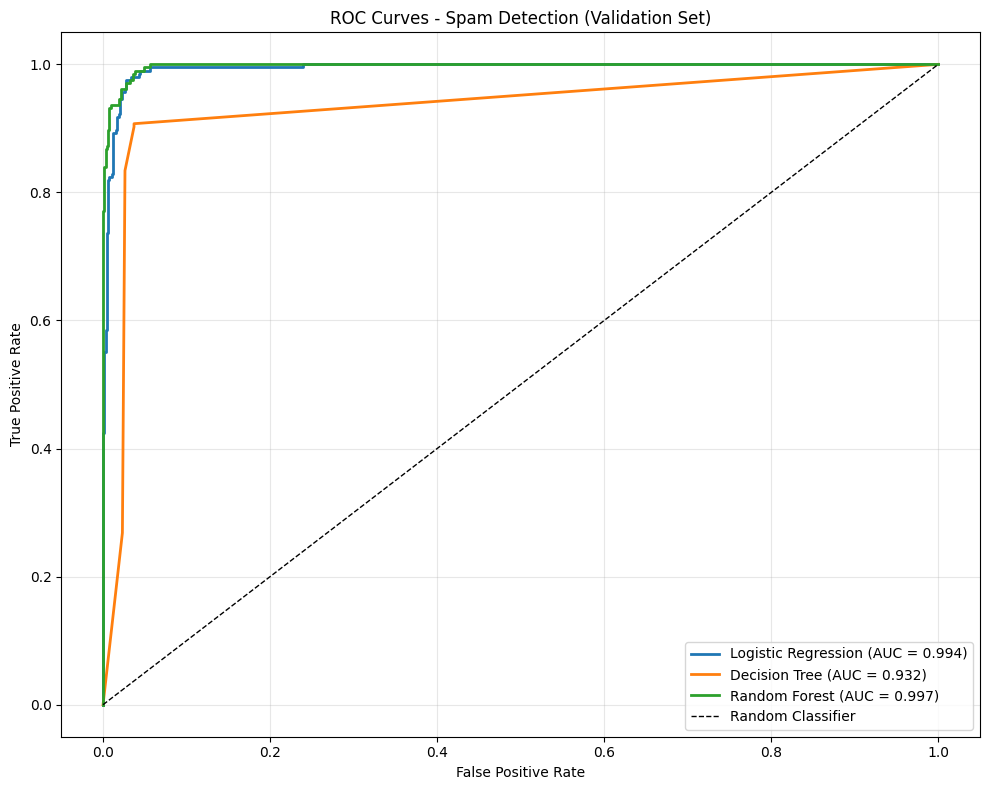


SPAM DETECTION - SUMMARY

Best Validation Performance: Logistic Regression (F1: 0.9395)
Best Test Performance: Logistic Regression (F1: 0.9346)


In [9]:
# ==========================================
# SPAM DETECTION - MODEL TRAINING
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import time
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("SPAM DETECTION - MODEL TRAINING")
print("="*70)
print(f"\nDataset: {len(X_train)} training samples, {len(X_val)} validation samples")
print(f"Features: {X_train.shape[1]} (16 manual + 100 TF-IDF)")
print(f"Task: Binary classification (Ham=0, Spam=1)\n")

# Dictionary to store results
spam_results = {}

# ==========================================
# 1. LOGISTIC REGRESSION
# ==========================================

print("-"*70)
print("1. LOGISTIC REGRESSION")
print("-"*70)

# Train on SCALED data
start_time = time.time()
lr_spam = LogisticRegression(random_state=42, max_iter=1000)
lr_spam.fit(X_train_scaled, y_train)
train_time_lr = time.time() - start_time

# Predict on validation set
start_time = time.time()
y_val_pred_lr = lr_spam.predict(X_val_scaled)
y_val_proba_lr = lr_spam.predict_proba(X_val_scaled)[:, 1]
inference_time_lr = time.time() - start_time

# Calculate metrics
accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
precision_lr = precision_score(y_val, y_val_pred_lr)
recall_lr = recall_score(y_val, y_val_pred_lr)
f1_lr = f1_score(y_val, y_val_pred_lr)
roc_auc_lr = roc_auc_score(y_val, y_val_proba_lr)

# Store results
spam_results['Logistic Regression'] = {
    'accuracy': accuracy_lr,
    'precision': precision_lr,
    'recall': recall_lr,
    'f1': f1_lr,
    'roc_auc': roc_auc_lr,
    'train_time': train_time_lr,
    'inference_time': inference_time_lr,
    'y_val_pred': y_val_pred_lr,
    'y_val_proba': y_val_proba_lr
}

print(f"Training time: {train_time_lr:.4f} seconds")
print(f"Inference time: {inference_time_lr:.4f} seconds")
print(f"\nValidation Metrics:")
print(f"  Accuracy:  {accuracy_lr:.4f}")
print(f"  Precision: {precision_lr:.4f} (of predicted spam, how many are actually spam)")
print(f"  Recall:    {recall_lr:.4f} (of actual spam, how many did we catch)")
print(f"  F1-Score:  {f1_lr:.4f}")
print(f"  ROC-AUC:   {roc_auc_lr:.4f}")

cm_lr = confusion_matrix(y_val, y_val_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)
tn, fp, fn, tp = cm_lr.ravel()
print(f"True Negatives (Ham→Ham): {tn}")
print(f"False Positives (Ham→Spam): {fp} ⚠️")
print(f"False Negatives (Spam→Ham): {fn} ⚠️")
print(f"True Positives (Spam→Spam): {tp}")

# ==========================================
# 2. DECISION TREE
# ==========================================

print("\n" + "-"*70)
print("2. DECISION TREE")
print("-"*70)

# Train on UNSCALED data
start_time = time.time()
dt_spam = DecisionTreeClassifier(random_state=42, max_depth=20)
dt_spam.fit(X_train, y_train)
train_time_dt = time.time() - start_time

# Predict on validation set
start_time = time.time()
y_val_pred_dt = dt_spam.predict(X_val)
y_val_proba_dt = dt_spam.predict_proba(X_val)[:, 1]
inference_time_dt = time.time() - start_time

# Calculate metrics
accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
precision_dt = precision_score(y_val, y_val_pred_dt)
recall_dt = recall_score(y_val, y_val_pred_dt)
f1_dt = f1_score(y_val, y_val_pred_dt)
roc_auc_dt = roc_auc_score(y_val, y_val_proba_dt)

# Store results
spam_results['Decision Tree'] = {
    'accuracy': accuracy_dt,
    'precision': precision_dt,
    'recall': recall_dt,
    'f1': f1_dt,
    'roc_auc': roc_auc_dt,
    'train_time': train_time_dt,
    'inference_time': inference_time_dt,
    'y_val_pred': y_val_pred_dt,
    'y_val_proba': y_val_proba_dt
}

print(f"Training time: {train_time_dt:.4f} seconds")
print(f"Inference time: {inference_time_dt:.4f} seconds")
print(f"\nValidation Metrics:")
print(f"  Accuracy:  {accuracy_dt:.4f}")
print(f"  Precision: {precision_dt:.4f}")
print(f"  Recall:    {recall_dt:.4f}")
print(f"  F1-Score:  {f1_dt:.4f}")
print(f"  ROC-AUC:   {roc_auc_dt:.4f}")

cm_dt = confusion_matrix(y_val, y_val_pred_dt)
print(f"\nConfusion Matrix:")
print(cm_dt)
tn, fp, fn, tp = cm_dt.ravel()
print(f"True Negatives: {tn} | False Positives: {fp}")
print(f"False Negatives: {fn} | True Positives: {tp}")

# ==========================================
# 3. RANDOM FOREST
# ==========================================

print("\n" + "-"*70)
print("3. RANDOM FOREST")
print("-"*70)

# Train on UNSCALED data
start_time = time.time()
rf_spam = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_spam.fit(X_train, y_train)
train_time_rf = time.time() - start_time

# Predict on validation set
start_time = time.time()
y_val_pred_rf = rf_spam.predict(X_val)
y_val_proba_rf = rf_spam.predict_proba(X_val)[:, 1]
inference_time_rf = time.time() - start_time

# Calculate metrics
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
precision_rf = precision_score(y_val, y_val_pred_rf)
recall_rf = recall_score(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf)
roc_auc_rf = roc_auc_score(y_val, y_val_proba_rf)

# Store results
spam_results['Random Forest'] = {
    'accuracy': accuracy_rf,
    'precision': precision_rf,
    'recall': recall_rf,
    'f1': f1_rf,
    'roc_auc': roc_auc_rf,
    'train_time': train_time_rf,
    'inference_time': inference_time_rf,
    'y_val_pred': y_val_pred_rf,
    'y_val_proba': y_val_proba_rf
}

print(f"Training time: {train_time_rf:.4f} seconds")
print(f"Inference time: {inference_time_rf:.4f} seconds")
print(f"\nValidation Metrics:")
print(f"  Accuracy:  {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall:    {recall_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")
print(f"  ROC-AUC:   {roc_auc_rf:.4f}")

cm_rf = confusion_matrix(y_val, y_val_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)
tn, fp, fn, tp = cm_rf.ravel()
print(f"True Negatives: {tn} | False Positives: {fp}")
print(f"False Negatives: {fn} | True Positives: {tp}")

# ==========================================
# 4. MODEL COMPARISON - VALIDATION SET
# ==========================================

print("\n" + "="*70)
print("MODEL COMPARISON - VALIDATION SET")
print("="*70)

comparison_spam = pd.DataFrame(spam_results).T
comparison_metrics = comparison_spam[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4)
comparison_time = comparison_spam[['train_time', 'inference_time']].round(4)

print("\nPerformance Metrics:")
print(comparison_metrics)

print("\n\nTraining & Inference Times:")
print(comparison_time)

print("\n\nBest Model per Metric:")
print(f"  Best Accuracy:  {comparison_spam['accuracy'].idxmax()} ({comparison_spam['accuracy'].max():.4f})")
print(f"  Best Precision: {comparison_spam['precision'].idxmax()} ({comparison_spam['precision'].max():.4f})")
print(f"  Best Recall:    {comparison_spam['recall'].idxmax()} ({comparison_spam['recall'].max():.4f})")
print(f"  Best F1-Score:  {comparison_spam['f1'].idxmax()} ({comparison_spam['f1'].max():.4f})")
print(f"  Best ROC-AUC:   {comparison_spam['roc_auc'].idxmax()} ({comparison_spam['roc_auc'].max():.4f})")

# ==========================================
# 5. TEST SET EVALUATION
# ==========================================

print("\n" + "="*70)
print("FINAL EVALUATION - TEST SET")
print("="*70)

spam_test_results = {}

for model_name, model in [('Logistic Regression', lr_spam),
                          ('Decision Tree', dt_spam),
                          ('Random Forest', rf_spam)]:
    print(f"\n{model_name}:")
    print("-" * 40)

    # Use appropriate data
    if model_name == 'Logistic Regression':
        X_test_use = X_test_scaled
    else:
        X_test_use = X_test

    # Predictions
    y_test_pred = model.predict(X_test_use)
    y_test_proba = model.predict_proba(X_test_use)[:, 1]

    # Metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    spam_test_results[model_name] = {
        'accuracy': test_acc,
        'precision': test_prec,
        'recall': test_rec,
        'f1': test_f1,
        'roc_auc': test_auc
    }

    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall:    {test_rec:.4f}")
    print(f"F1-Score:  {test_f1:.4f}")
    print(f"ROC-AUC:   {test_auc:.4f}")

    cm = confusion_matrix(y_test, y_test_pred)
    print(f"Confusion Matrix:\n{cm}")
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    print(f"False Positive Rate: {fpr:.4f} ({fp} ham emails marked as spam)")
    print(f"False Negative Rate: {fnr:.4f} ({fn} spam emails missed)")

# ==========================================
# 6. FEATURE IMPORTANCE
# ==========================================

print("\n" + "="*70)
print("RANDOM FOREST - FEATURE IMPORTANCE")
print("="*70)

feature_importance_spam = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_spam.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_spam.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance_spam.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Spam Detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ==========================================
# 7. ROC CURVES
# ==========================================

print("\n" + "="*70)
print("ROC CURVE COMPARISON")
print("="*70)

plt.figure(figsize=(10, 8))

for model_name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
    y_proba = spam_results[model_name]['y_val_proba']
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc = spam_results[model_name]['roc_auc']

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Spam Detection (Validation Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================================
# 8. SUMMARY
# ==========================================

print("\n" + "="*70)
print("SPAM DETECTION - SUMMARY")
print("="*70)

val_f1_spam = {k: v['f1'] for k, v in spam_results.items()}
test_f1_spam = {k: v['f1'] for k, v in spam_test_results.items()}

best_val = max(val_f1_spam, key=val_f1_spam.get)
best_test = max(test_f1_spam, key=test_f1_spam.get)

print(f"\nBest Validation Performance: {best_val} (F1: {val_f1_spam[best_val]:.4f})")
print(f"Best Test Performance: {best_test} (F1: {test_f1_spam[best_test]:.4f})")

In [10]:
# ==========================================
# EXPORT SPAM DETECTION MODELS
# ==========================================

import pickle
import os

# Create directory for models
os.makedirs('spam_models', exist_ok=True)

print("="*70)
print("EXPORTING SPAM DETECTION MODELS")
print("="*70)

# Save Random Forest model
with open('spam_models/spam_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_spam, f)
print("✓ Random Forest model saved")

# Save TF-IDF vectorizer (CRITICAL for text processing)
with open('spam_models/spam_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("✓ TF-IDF vectorizer saved")

# Save feature scaler
with open('spam_models/spam_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Feature scaler saved")

# Save spam keywords for manual features
spam_keywords = ['free', 'win', 'winner', 'cash', 'prize', 'offer', 'click', 'urgent', 'limited']
with open('spam_models/spam_keywords.pkl', 'wb') as f:
    pickle.dump(spam_keywords, f)
print("✓ Spam keywords saved")

# Save Logistic Regression model too (optional - it performed well)
with open('spam_models/spam_lr_model.pkl', 'wb') as f:
    pickle.dump(lr_spam, f)
print("✓ Logistic Regression model saved (optional)")

# Verify files
print("\n" + "="*70)
print("VERIFICATION")
print("="*70)

model_files = os.listdir('spam_models')
print(f"\nFiles created: {len(model_files)}")
for file in sorted(model_files):
    filepath = os.path.join('spam_models', file)
    size = os.path.getsize(filepath) / 1024  # KB
    print(f"  ✓ {file} ({size:.2f} KB)")

# Create zip file
import shutil
shutil.make_archive('spam_models', 'zip', 'spam_models')
print("\n✓ Created 'spam_models.zip'")

# Download from Colab
from google.colab import files
files.download('spam_models.zip')
print("✓ Download started - check your browser downloads")

print("\n" + "="*70)
print("SPAM MODELS EXPORT COMPLETE!")
print("="*70)

EXPORTING SPAM DETECTION MODELS
✓ Random Forest model saved
✓ TF-IDF vectorizer saved
✓ Feature scaler saved
✓ Spam keywords saved
✓ Logistic Regression model saved (optional)

VERIFICATION

Files created: 5
  ✓ spam_keywords.pkl (0.09 KB)
  ✓ spam_lr_model.pkl (1.61 KB)
  ✓ spam_rf_model.pkl (2227.15 KB)
  ✓ spam_scaler.pkl (4.53 KB)
  ✓ spam_tfidf.pkl (4.24 KB)

✓ Created 'spam_models.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download started - check your browser downloads

SPAM MODELS EXPORT COMPLETE!
